Faculdade: EMAP-FGV | 
Disciplina: Modelagem Estatística | 
Professor: Claudio José Struchiner | 
Aluno: Victor Vilanova Bandeira

# Modelo MCMC para inferências entorno do BITCOIN

MCMC is a computer–driven sampling method (Gamerman and Lopes 2006; Gilks et al. 1996).
MCMC - Morkov Chain Monte Carlo são uma classe de algoritmos que nos permite amostrar a posteriori de distribuições nos casos que são difíceis de trabalhar via análises analíticas.

Dessa forma, em uma inferência Bayesiana tradicional, temos os parâmetros, a verrossimilhança, e as prioris que temos dos parâmetros para virarem assim a posterior das nossas crenças dos parâmetros. Tudo isso, seguindo a formula de Bayes:

$$ p(\mu|D) \sim p(D|\mu)p(\mu) $$

onde $p(\mu|D)$ é a probabilidade de $\mu$ dado os dados, $p(D|\mu)$ indica a verrosimilhança e $p(\mu) a priori.

Assim, quando a expressão analítica da verrossimilhança é alcançável, combinada com a piori podemos derivar a posteriori analiticamente. Porém, algumas vezes isso não é possível em prática. Dessa forma, esse problema na estatística é resolvido por meio do MCMC: que desenha uma amostragem de amostras da posterior.

# Uma pequena introdução a MCMC

Os dados que vamos usar foram retirados do kaggle. Representam série de tempo diárias históricas para moeda digital (BTC - Bitcoin) negociadas no mercado saudita (SAR / Sudi Riyal). Sendo assim, estipularemos primeiramente sua liquidez e , após isso, seu valor comercial diário em dólar. Usando para isso o método de Markov chain Monte Carlo (MCMC), mais especificamente usaremos Metropolis-Hastings algorithm. 

Para atingir esse objetivo, usaremos a biblioteca pymc3 que possui todo ferramental que precisaremos.

##### Importando os pacotes

In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statistics
  

# matplotlib for plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns
sns.set()

# scipy for algorithms
import scipy
from scipy import stats

##### Importando os dados

In [2]:
data = pd.read_csv('dc.csv')

In [3]:
data.isnull().values.any()

False

In [4]:
data.describe()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,34825.322255,9285.762120,35789.618165,9542.880270,33796.329057,9011.393200,34917.483572,9310.335850,53100.498000
std,21728.028028,5793.522832,22785.946842,6075.604427,20565.410145,5483.524463,21928.280072,5846.917681,35329.832031
min,12045.197184,3211.710000,12288.185600,3276.500000,11837.237504,3156.260000,12045.234688,3211.720000,5743.000000
25%,24254.558752,6467.192500,24686.089152,6582.255000,23721.336256,6325.015000,24252.946080,6466.762500,30045.750000
50%,30714.632128,8189.695000,31321.953152,8351.630000,30010.869568,8002.045000,30713.263232,8189.330000,43795.500000
75%,38317.311744,10216.860000,39077.527200,10419.562500,37158.878816,9907.977500,38329.725568,10220.170000,64909.250000
max,152217.334784,40586.960000,157329.280000,41950.000000,145215.488000,38720.000000,152201.770624,40582.810000,402201.000000


In [5]:
data.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [6]:
data.columns

Index(['Unnamed: 0', 'open_SAR', 'open_USD', 'high_SAR', 'high_USD', 'low_SAR',
       'low_USD', 'close_SAR', 'close_USD', 'volume'],
      dtype='object')

## Primeira análise liquidez do ativo

Para primeira hipótese, iremos supor que o valor diário de liquidez da moeda Bitcoin comercializada será a subtração do fechamento e da abertura do ativo diária.

In [7]:
USD_liq = (data['close_USD'] - data['open_USD'])
USD_liq.head()

0     -27.74
1     884.02
2    3002.67
3   -2097.86
4     213.58
dtype: float64

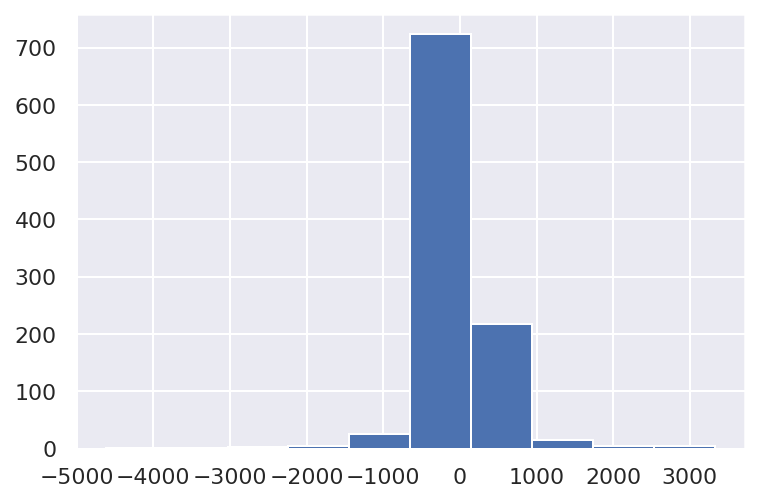

In [8]:
plt.hist(USD_liq);

In [9]:
USD_liq = np.array(USD_liq)

### Modelo MCMC


As váriaveis mu e sigma terão como prioris distribuições normal e uniforme, respectivamente, com um alto espassamento de forma ao modelo escolher qual espaço elas devem ficar.
$$ \mu \sim Norm \ e \ \sigma \sim Unif $$

Além disso, nossa variável de interesse será uma verrossimilhança de distribuição Normal.



In [10]:
%%time
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0.0, tau=0.01, testval=0.0)
    sigma = pm.Uniform('sigma',lower=0, upper=1000)
    
    S = pm.Normal('S', mu=mu, sigma=sigma, observed=USD_liq)
    
    N_SAMPLE = 5000
    
    step = pm.Metropolis()
    
    trace = pm.sample(N_SAMPLE, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 2.68 s, sys: 267 ms, total: 2.95 s
Wall time: 4.68 s


### Construindo o diagnóstico

In [11]:
mu_samples = trace["mu"][5000:,None]
sigma_samples = trace["sigma"][5000:,None]

### Trace plot

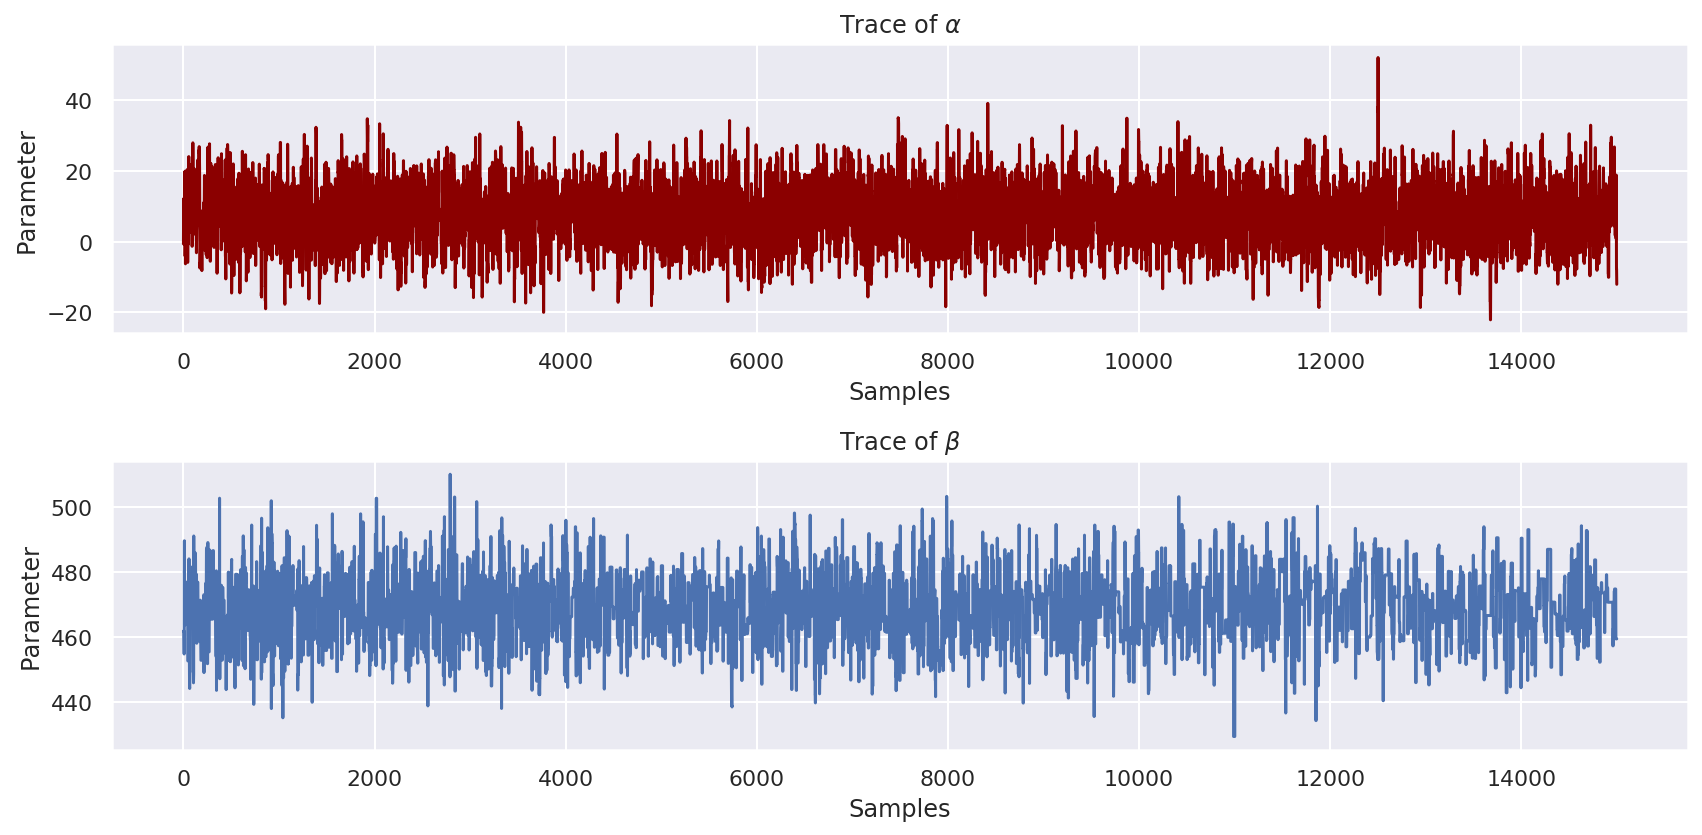

In [12]:
figsize(12,6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(mu_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(sigma_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


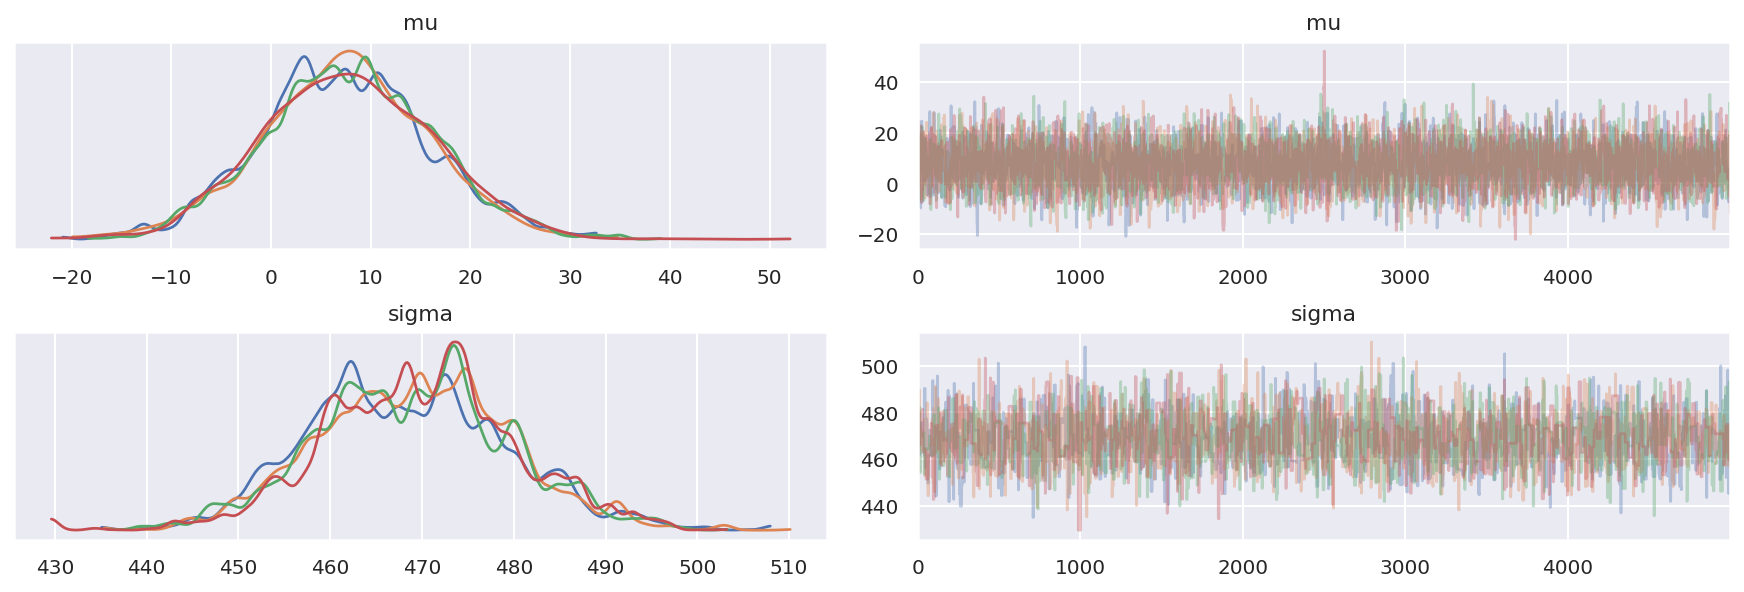

In [13]:
pm.plot_trace(trace);

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


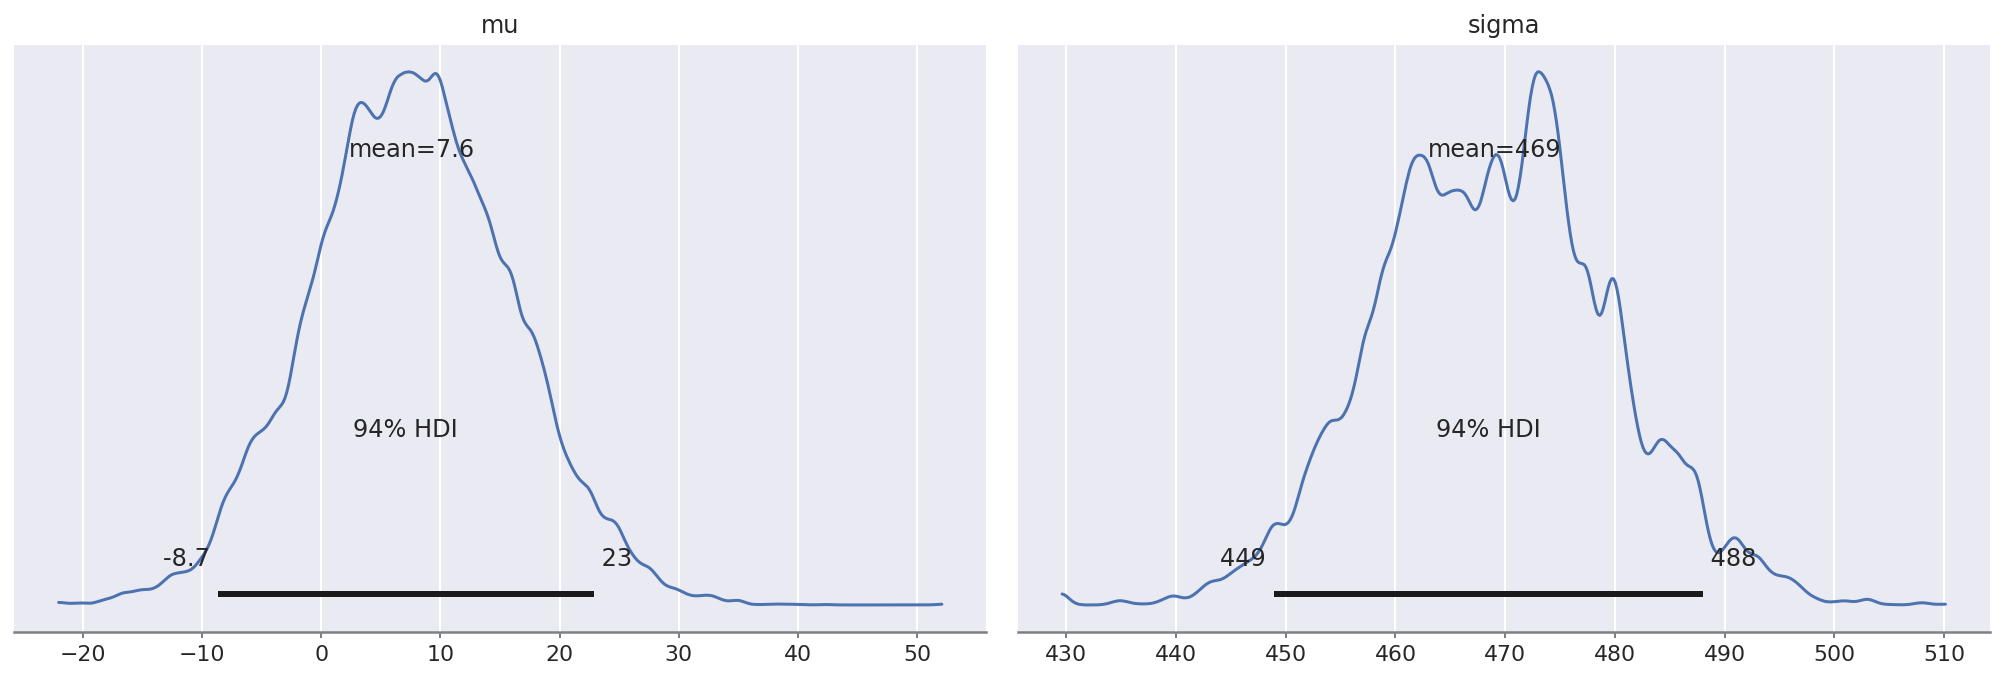

In [14]:
figsize(6,4)
pm.plot_posterior(trace);

Perceba que nosso modelo achou que a média dos nossos parâmetros $\mu$ foi de 7.5 e a média de $\sigma$ de 468

In [15]:
new_mu = trace["mu"].mean()
new_mu

7.569629201210699

In [16]:
new_sigma = trace["sigma"].mean()
new_sigma

469.0754605569835

Podemos plotar a posteriori da nossa variável de interesse

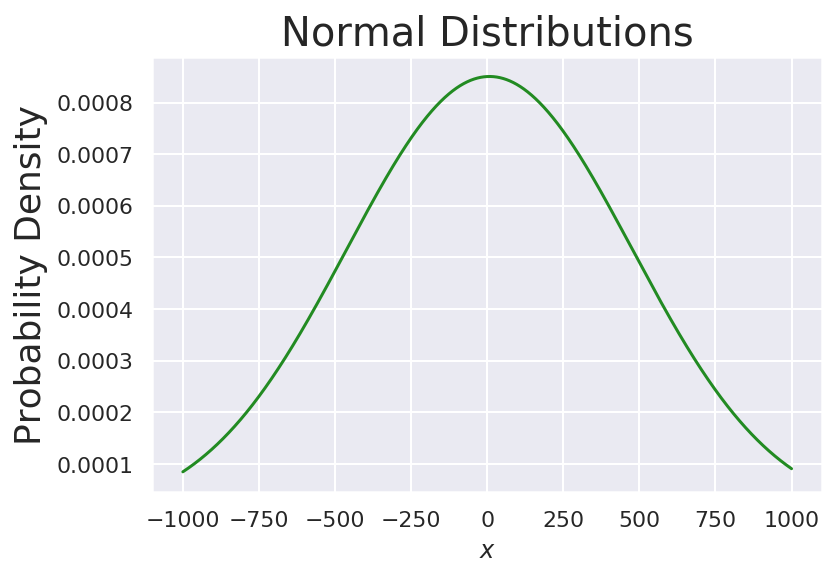

In [17]:
x_axis = np.arange(-1000, 1000, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, new_mu, new_sigma), color = "forestgreen")
plt.xlabel("$x$")
plt.ylabel("Probability Density", size = 18)
plt.title("Normal Distributions", size = 20);
plt.show()

## Uma segunda análise da média diária do valor do ativo

Para a segunda análise, queremos identificar a distribuição do preço da BITCOIN em dólar no período estudado, dessa forma:
Começaremos com uma simplificação de que o valor do nosso ativo é discreto diariamente, dessa forma passaremos como dado a média do valor diária do ativo.

Ou seja, a média da alta e da baixa diária do ativo

In [18]:
USD_mean = (data.high_USD + data.low_USD) / 2
USD_mean.head()

0    33879.000
1    35223.650
2    31813.040
3    30899.505
4    31879.625
dtype: float64

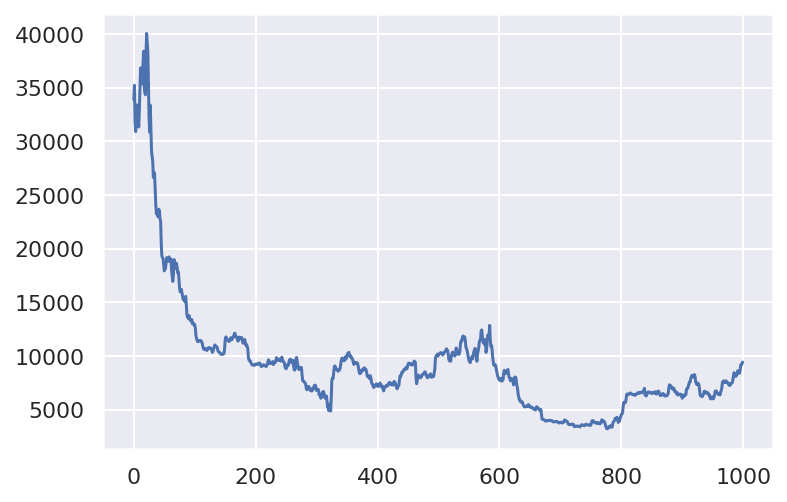

In [19]:
USD_mean.plot()

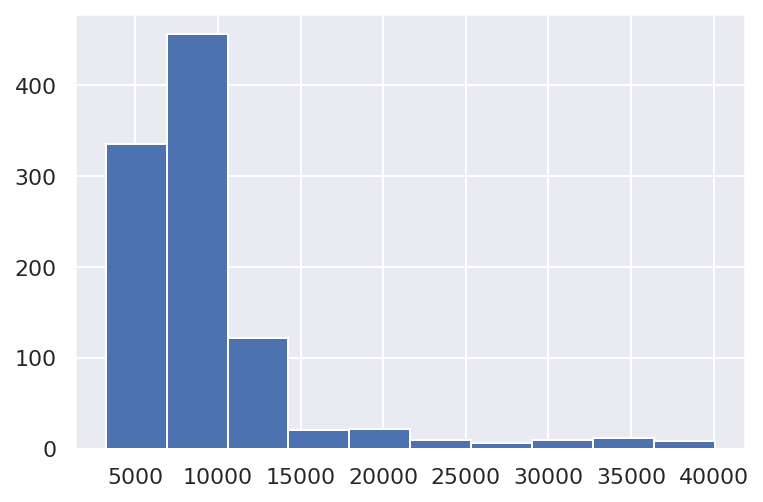

In [20]:
USD_mean.hist()

In [21]:
USD_mean = np.array(USD_mean)

### Modelo MCMC

As váriaveis mu e sigma terão como prioris distribuições normal e uniforme, respectivamente, com um alto espassamento de forma ao modelo escolher qual espaço elas devem ficar.
$$ \mu \sim Norm \ e \ \sigma \sim Unif $$

Além disso, a c.d.f. uma distribuição Lognormal.


In [22]:
%%time
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0.0, tau=0.01, testval=0.0)
    sigma = pm.Uniform('sigma', lower=0, upper=800)
    
    S = pm.Lognormal('S', mu=mu, sigma=sigma, observed=USD_mean)
    
    N_SAMPLE = 5000
    
    trace = pm.sample(N_SAMPLE)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8788726039897976, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 3.63 s, sys: 200 ms, total: 3.83 s
Wall time: 5.3 s


### Construindo o diagnóstico

In [23]:
mu_samples = trace["mu"][5000:,None]
sigma_samples = trace["sigma"][5000:,None]

### Trace plot

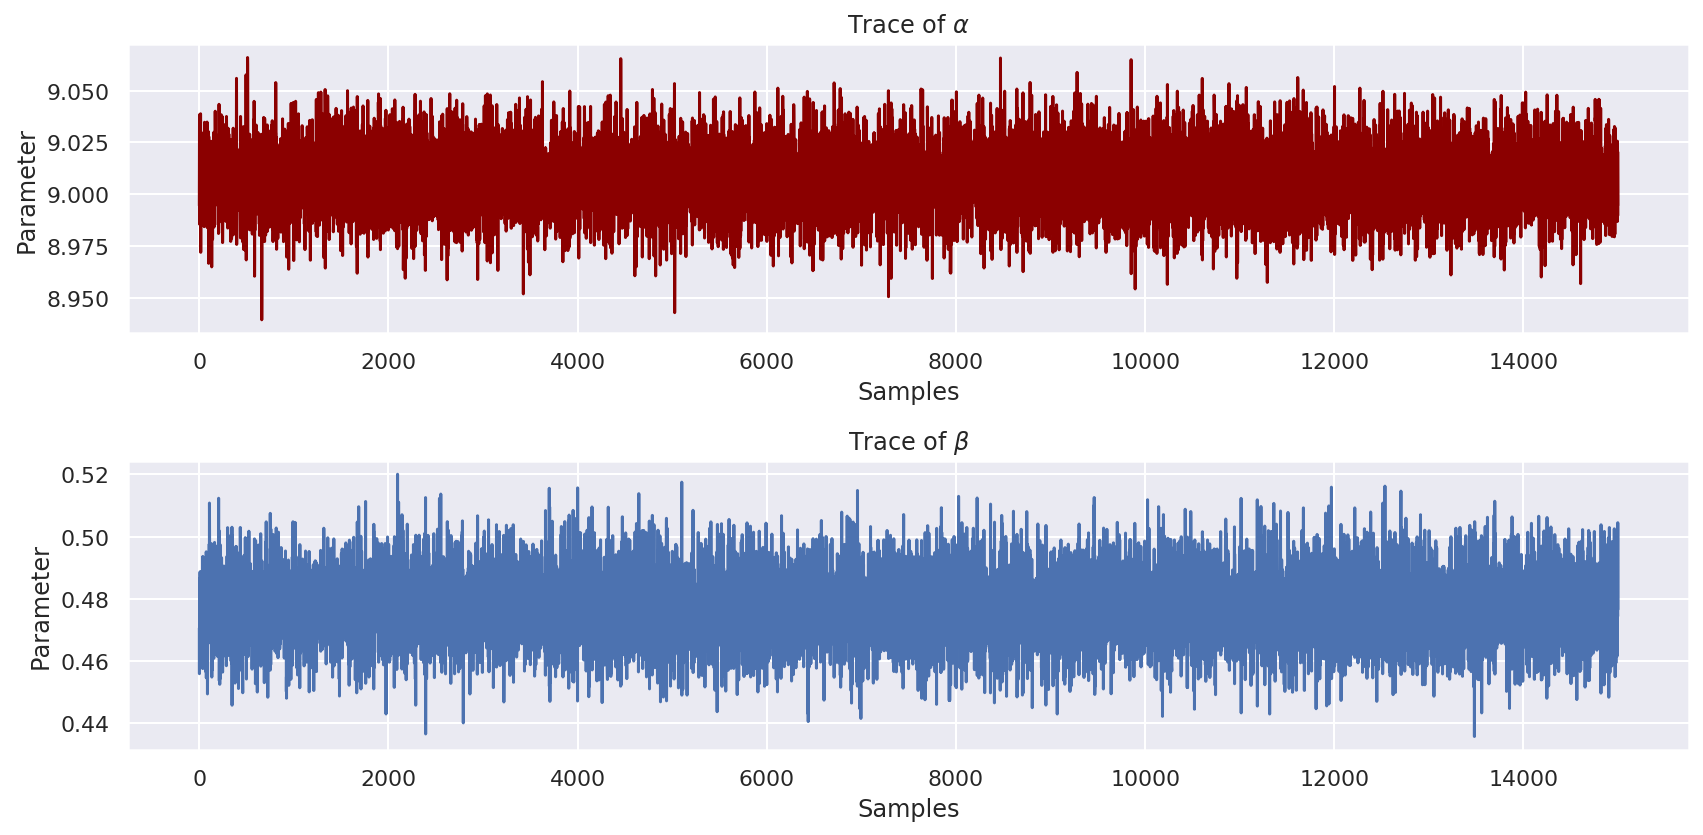

In [24]:
figsize(12,6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(mu_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(sigma_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


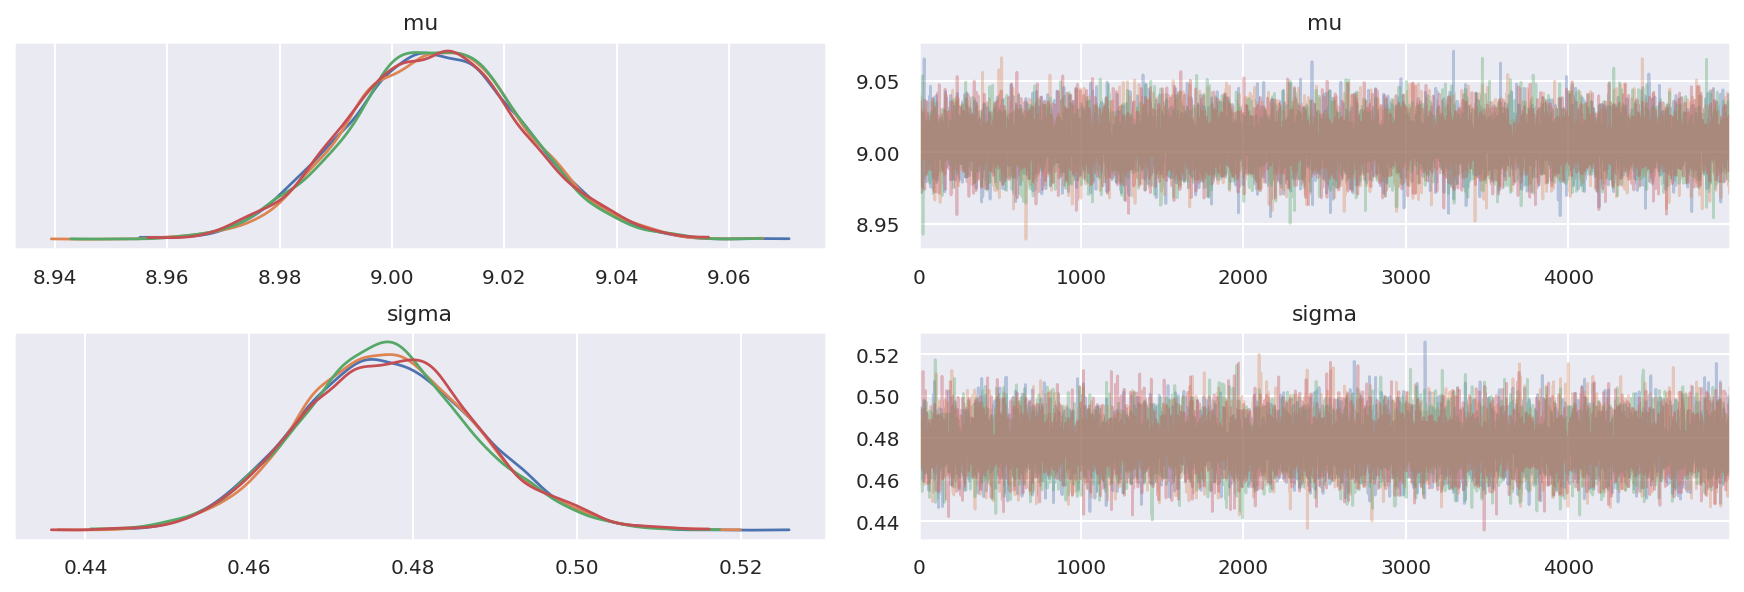

In [25]:
pm.plot_trace(trace);

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


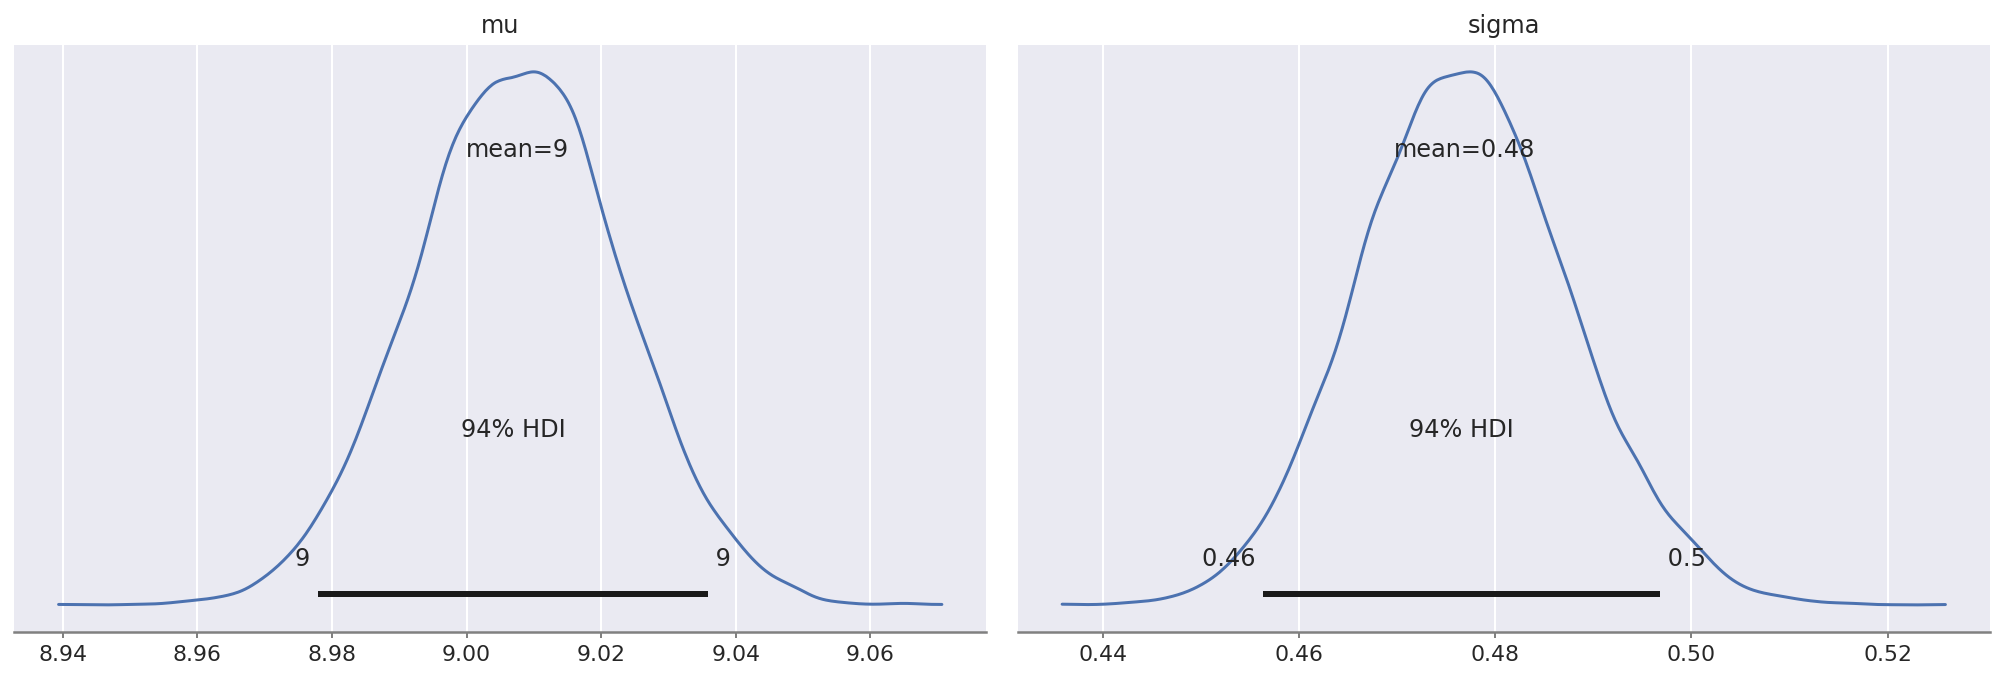

In [26]:
figsize(6,4)
pm.plot_posterior(trace);

Perceba que nosso modelo achou que a média dos nossos parâmetros $\mu$ foi de 9 e a média de $\sigma$ de 0.48

In [27]:
new_mu = trace["mu"].mean()
new_mu

9.00754898126472

In [28]:
new_sigma = trace["sigma"].mean()
new_sigma

0.47687909849756854

## Será que a aproximação de calcular a média do ativo diária foi uma boa escolha?

A resposta é não! 
Para estipularmos os intervalos, precisamos mudar a p.d.f. de dentro da verrossimilhança como diferença de c.d.f.s.

Na abordagem anterior:
Tinhamos observações do tipo $\boldsymbol{T} = (T_1, \dots, T_n)$ que nos dava uma verrossimilhança:
$$ L(\mu, \sigma \mid \boldsymbol{T}) = \prod_{i=1}^n f(T_i; \mu, \sigma )  $$

onde $f(x; \mu, \sigma)$ é a p.d.f. da distribuição $\mathsf{LogNormal}(\mu, \sigma^2)$.


No entanto, não temos observações, apenas intervalos. Nossos dados são do tipo $T_i \in [T_i^-, T_i^+]$. Assim, nossa verrossimilhança será:

$$ L(\mu, \sigma \mid \boldsymbol{T}^{\,-}, \boldsymbol{T}^{\,+}) = \prod_{i=1}^n \bigl[ F(T_i^+ ; \mu, \sigma) - F(T_i^-; \mu, \sigma) \bigr] $$

onde $F(x; \mu, \sigma)$ é a c.d.f. da distribuição $\mathsf{LogNormal}(\mu, \sigma^2)$.

In [29]:
import theano.tensor as tt

#funções para alterarmos a verrossimilhança.
def zvalue(x, sigma, mu):

    return (x - mu) / sigma

def cdf(x, mu, sigma):

        z = zvalue(np.log(x), mu=mu, sigma=sigma)

        return tt.switch(
                tt.lt(z, -1.0),
                tt.erfcx(-z / tt.sqrt(2.)) / 2. * np.exp(-tt.sqr(z) / 2),
                tt.erfc(-z / tt.sqrt(2.)) / 2.
        )

In [30]:
USD_high = np.array(data.high_USD)
USD_low = np.array(data.low_USD)

In [31]:
%%time
with pm.Model() as model:
    μ = pm.Normal('μ', mu=500, tau=0.01, testval=0.0)
    σ = pm.Uniform('σ', lower=0, upper=500) 
    pm.Potential('T', tt.sum(tt.log( cdf(USD_high, μ, σ) - cdf(USD_low, μ, σ) )))
    trace = pm.sample(10**5, step=pm.Metropolis()) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [μ]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 58 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 39.3 s, sys: 2.42 s, total: 41.7 s
Wall time: 59.2 s


### Construindo o diagnóstico

In [32]:
mu_samples = trace['μ'][5000:, None]
sigma_samples = trace['σ'][5000:, None]

### Trace plot

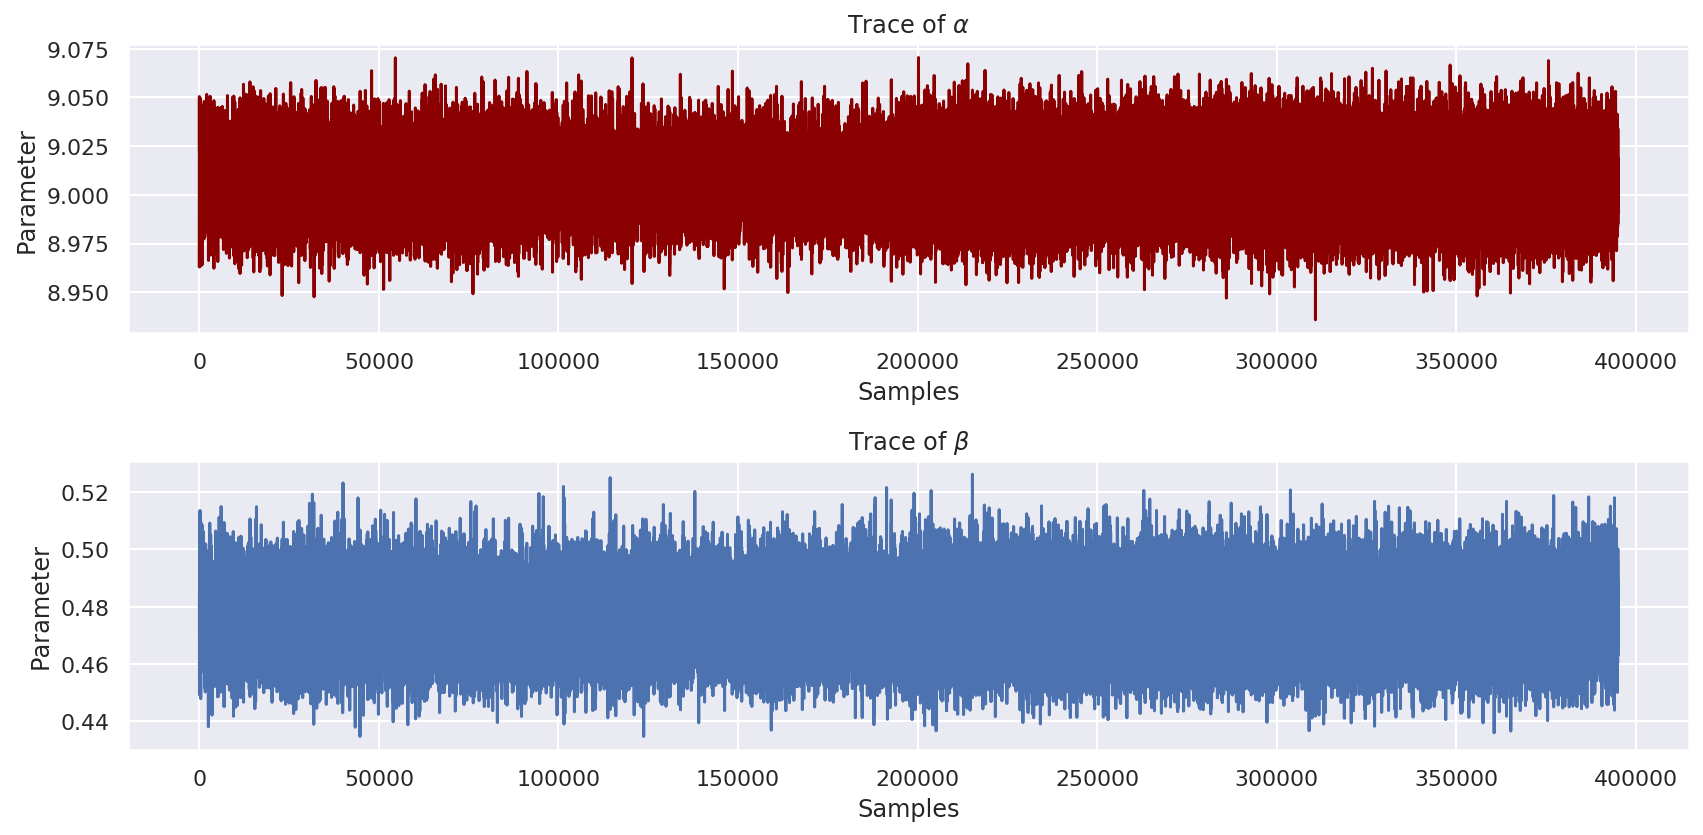

In [33]:
figsize(12,6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(mu_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(sigma_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


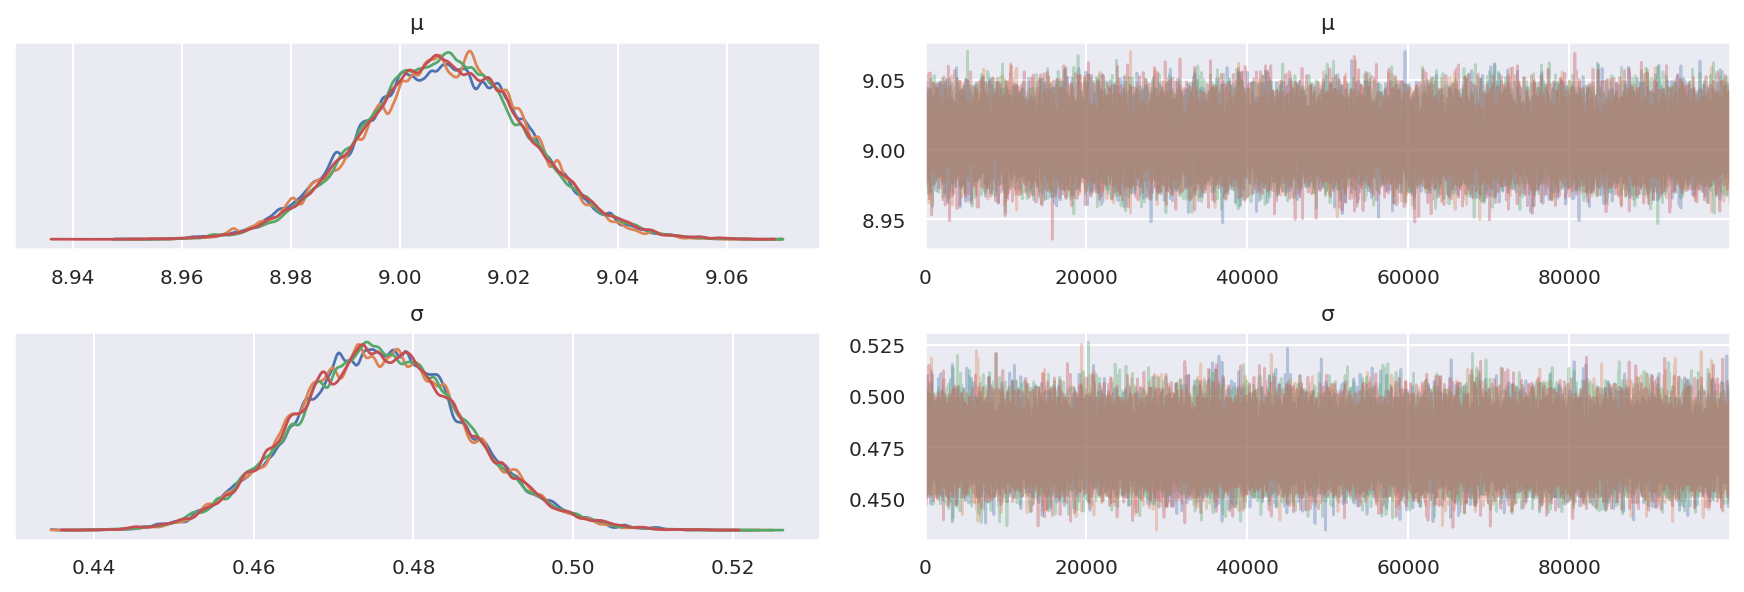

In [34]:
pm.plot_trace(trace);

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


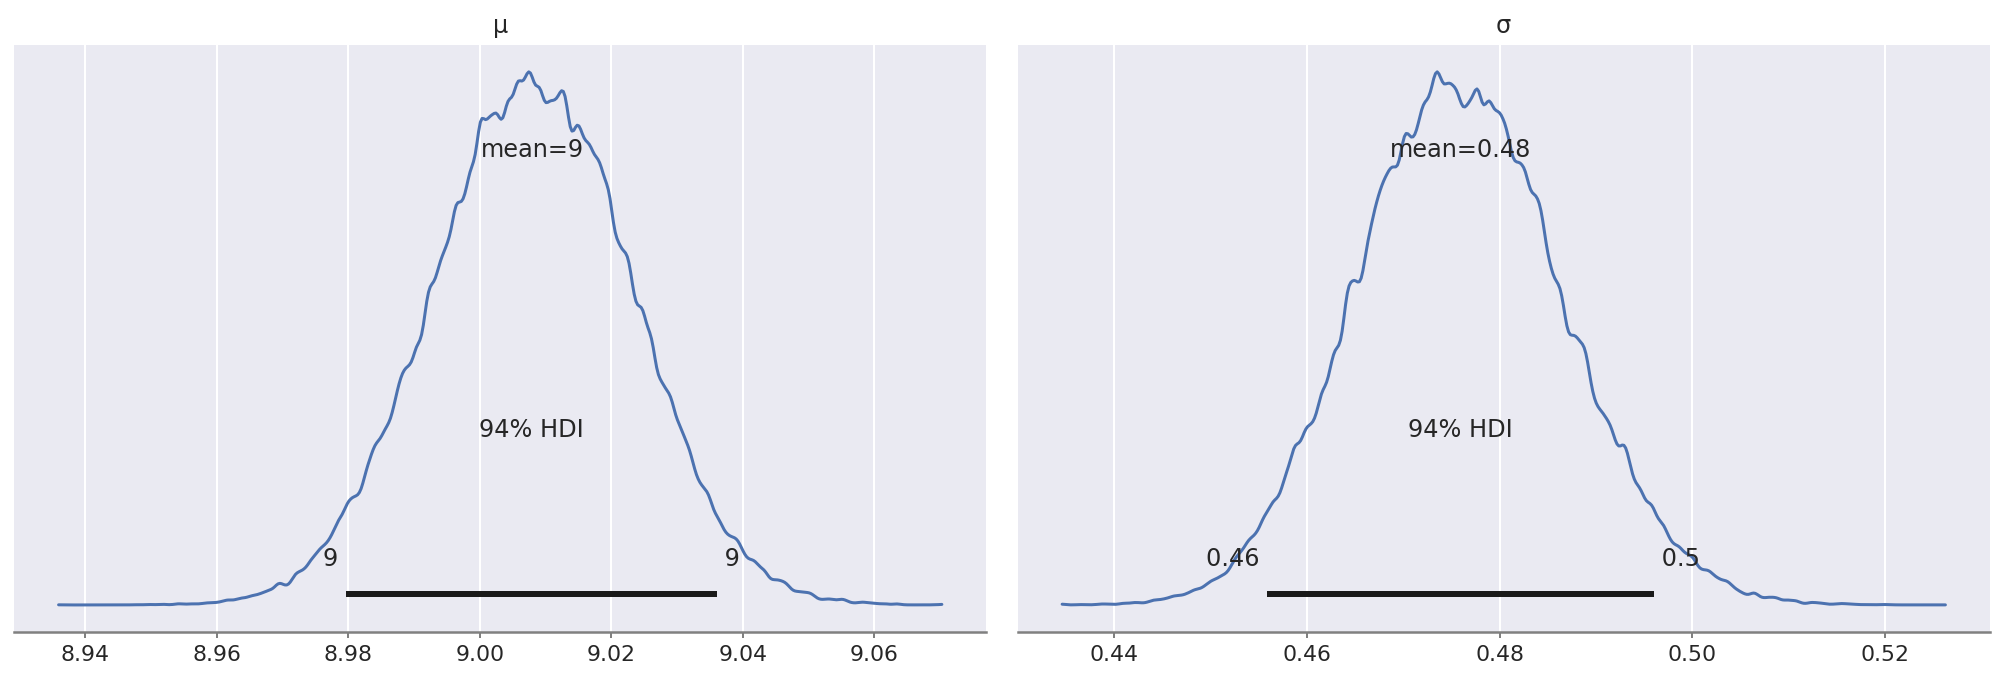

In [35]:
figsize(6,4)
pm.plot_posterior(trace);

Perceba que nosso modelo achou que a média dos nossos parâmetros $\mu$ se manteve de 9 e a média de $\sigma$ de 0.48